# Read Data from the Cloud

```{article-info}
:author: Altay Sansal
:date: "{sub-ref}`today`"
:read-time: "{sub-ref}`wordcount-minutes` min read"
:class-container: sd-p-0 sd-outline-muted sd-rounded-3 sd-font-weight-light
```

In this tutorial, we will use a public SEG-Y file located in Amazon Web Services' (AWS)
Simple Storage Service (S3), also known as a cloud object store.

This dataset, the Parihaka 3D full angle stack (4.7 GB per volume including full angle
and near, mid, and far stacks), is provided by New Zealand Petroleum and Minerals (NZPM).
Available information and data acquisition details are accessible via the
[SEG Wiki][seg wiki], the [New Zealand GNS website], and the [NZPM data portal].

[seg wiki]: https://wiki.seg.org/wiki/Parihaka-3D
[nzpm data portal]: http://data.nzpam.govt.nz/GOLD/system/mainframe.asp
[new zealand gns website]: http://www.gns.cri.nz

```{important}
For plotting, the notebook requires [Matplotlib](https://matplotlib.org/) as a dependency.
Please install it before executing using `pip install matplotlib` or `conda install matplotlib`.
```

Let's start by importing some modules we will be using.

In [1]:
import json

import matplotlib.pyplot as plt
from IPython.display import JSON
from numpy.random import default_rng

from segy import SegyFile
from segy.config import SegyFileSettings
from segy.schema import StructuredFieldDescriptor
from segy.standards import rev1_segy

You can (but don't) download the SEG-Y directly clicking the [HTTP link] from the website.

[http link]: http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/PARIHAKA-3D/Parihaka_PSTM_full_angle.sgy

This link is convenient as the `segy` library supports HTTP and we can directly use it
without downloading as well. Hovewer, For demonstration purposes, we'll use the 
corresponding S3 link (or called bucket and prefix):

`s3://open.source.geoscience/open_data/newzealand/Taranaiki_Basin/PARIHAKA-3D/Parihaka_PSTM_full_angle.sgy`

It's important to note that the file isn't downloaded but rather read on demand from the
S3 object store with the `segy` library. 

The `SegyFile` class uses information from the binary file header to construct a SEG-Y
descriptor, allowing it to read the file. The SEG-Y Revision is inferred from the binary
header by default, but can be manually set by adjusting the `revision` setting.

Since this is a public bucket and an object, we need to tell `S3` that we want anonymous
access, which is done by configuring `storage_options` in settings.

In [2]:
path = "s3://open.source.geoscience/open_data/newzealand/Taranaiki_Basin/PARIHAKA-3D/Parihaka_PSTM_full_angle.sgy"

# Alternatively via HTTP
# path = "http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/PARIHAKA-3D/Parihaka_PSTM_full_angle.sgy"

settings = SegyFileSettings(storage_options={"anon": True})

sgy = SegyFile(path, settings=settings)

Let's investigate the JSON version of the descriptor.

Some things to note:
1. The opening processed inferred Revision 1 from the binary header automatically.
2. It generated the schema using **default** SEG-Y Revision 1 headers.
3. Some headers can be defined in the wrong byte locations, we can check that.
4. Way to many headers to deal with in the default schema.

Note that we can build this JSON independently, load it into the descriptor
and open any SEG-Y with a shema.

In [3]:
JSON(json.loads(sgy.spec.model_dump_json()))

<IPython.core.display.JSON object>

Let's check the file size, number of traces, sample rate, etc. As expected, the file size
matches what was in the description. We also observe there are ~ 1 million traces.

In [4]:
print(f"file size: {sgy.file_size / 1024**3:0.2f} GiB")
print(f"num traces: {sgy.num_traces:,}")
print(f"sample rate: {sgy.sample_interval}")
print(f"num samples: {sgy.samples_per_trace}")
print(f"sample labels: {sgy.sample_labels // 1000}")  # microsecond to millisecond

file size: 4.75 GiB
num traces: 1,038,162
sample rate: 3000
num samples: 1168
sample labels: [   0    3    6 ... 3495 3498 3501]


Using the `SegyFile` we can read SEG-Y components.

Here we read:
- Textual file header
- Binary file header
- 1,000 traces (headers + data) from somewhere in the middle of the file

In [5]:
text_header = sgy.text_header
binary_header = sgy.binary_header

start = 500_000
stop = start + 1_000

traces = sgy.trace[start:stop]

trace_headers = traces.header
trace_data = traces.sample

This should take around one second or less, based on internet connection.

Let's print the textual header. There are a not many headers of interest. The
available headers appear to be in the Revision 1 byte locations.

In [6]:
print(text_header)

C 1 3D VOLUME                                                                   
C 2 HEADER BYTE LOCATIONS AND TYPES:                                            
C 3     3D INLINE : 189-192 (4-BYTE INT)    3D CROSSLINE: 193-196 (4-BYTE INT)  
C 4     ENSEMBLE X: 181-184 (4-BYTE INT)    ENSEMBLE Y  : 185-188 (4-BYTE INT)  
C 5                                                                             
C 6 SAMPLES/TRACE     :       1168                                              
C 7 SAMPLE INTERVAL   :       3000 microseconds                                 
C 8 FIRST SAMPLE AT   :          0 ms                                           
C 9 VERTICAL DIMENSION: TWT (ms)                                                
C10 SAMPLE RECORDING FORMAT: IBM FLOATING POINT (4-BYTE)                        
C11                                                                             
C12                                                                             
C13                         

We can look at headers (by default it is a Pandas `DataFrame`) in a nicely formatted table. 

We can also do typical Pandas analytics (like plots, statistics, etc.) but it won't be shown here.

In [7]:
binary_header.to_dataframe()

,job_id,line_no,reel_no,data_traces_ensemble,aux_traces_ensemble,sample_interval,sample_interval_orig,samples_per_trace,samples_per_trace_orig,data_sample_format,...,correlated_traces,binary_gain,amp_recovery_method,measurement_system,impulse_signal_polarity,vibratory_polarity,seg_y_revision,fixed_length_trace_flag,extended_textual_headers,additional_trace_headers
0,0,0,0,0,0,3000,0,1168,0,1,...,0,0,0,0,0,0,256,1,0,0


In [8]:
trace_headers.to_dataframe()

,trace_seq_line,trace_seq_file,field_rec_no,trace_no_field_rec,energy_src_pt,cdp_ens_no,trace_no_ens,trace_id,vert_sum,horiz_stack,...,transduction_constant_exponent,transduction_units,device_trace_id,times_scalar,source_type_orientation,source_energy_direction_mantissa,source_energy_direction_exponent,source_measurement_mantissa,source_measurement_exponent,source_measurement_unit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's plot the traces.

Note that they are all parsed from IBM floats to IEEE floats (decoded) in the background.

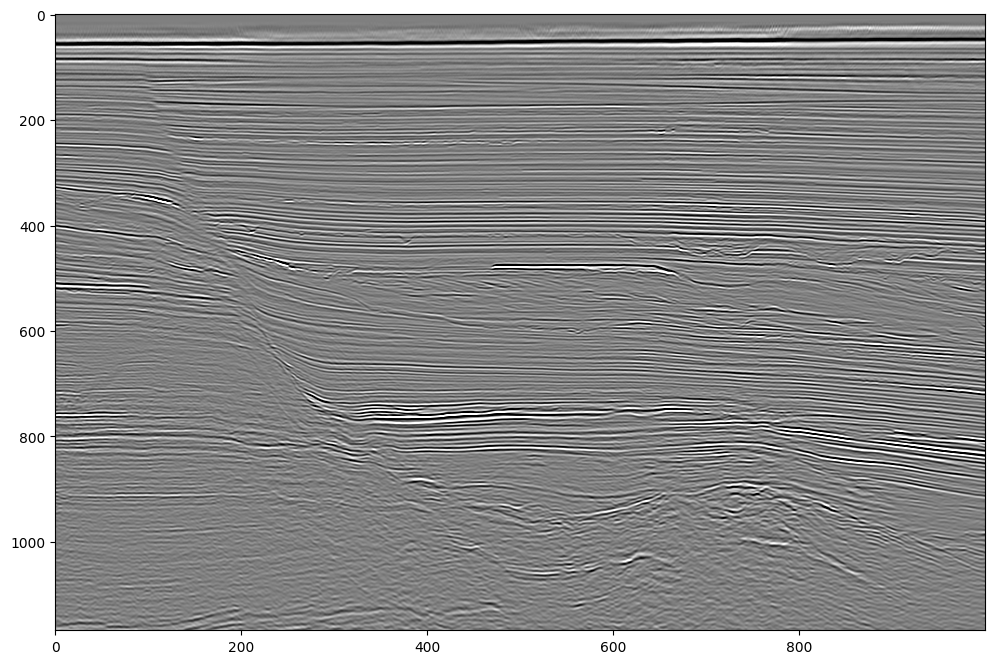

In [9]:
plt.figure(figsize=(12, 8))
plot_kw = {"aspect": "auto", "cmap": "gray_r", "interpolation": "bilinear"}
plt.imshow(trace_data.T, vmin=-1000, vmax=1000, **plot_kw);

## With Custom Schema

We will create a new custom schema based on SEG-Y revision 1 with different binary
and trace headers. This way we will parse ONLY the parts we want, with correct byte
locations.

A user can define a completely custom SEG-Y schema from scratch as well, but for
convenience, we are customizing Revision 1 schema with the parts that we want to
customize.

Note that doing this will also modify the `segyStandard` field to `"custom"` to
make sure we don't assume the file schema is standard after doing this.

From the binary file header we will read:
- Number of samples
- Sample rate

From the trace headers, we will read:
- Inline
- Crossline
- CDP-X
- CDP-Y
- Coordinate scalar

Based on the text header lines:

```
C 2 HEADER BYTE LOCATIONS AND TYPES:                                            
C 3     3D INLINE : 189-192 (4-BYTE INT)    3D CROSSLINE: 193-196 (4-BYTE INT)  
C 4     ENSEMBLE X: 181-184 (4-BYTE INT)    ENSEMBLE Y  : 185-188 (4-BYTE INT)   
```

And we know by SEG-Y Rev1 definition, the coordinate scalars are at byte 71.

In [10]:
custom_spec = rev1_segy.customize(
    binary_header_fields=[
        StructuredFieldDescriptor(name="sample_interval", offset=16, format="int16"),
        StructuredFieldDescriptor(name="samples_per_trace", offset=20, format="int16"),
    ],
    trace_header_fields=[
        StructuredFieldDescriptor(name="inline", offset=188, format="int32"),
        StructuredFieldDescriptor(name="crossline", offset=192, format="int32"),
        StructuredFieldDescriptor(name="cdp-x", offset=180, format="int32"),
        StructuredFieldDescriptor(name="cdp-y", offset=184, format="int32"),
        StructuredFieldDescriptor(name="coordinate_scalar", offset=70, format="int16"),
    ],
)

sgy = SegyFile(path, spec=custom_spec, settings=settings)

Now let's look at the JSON for the desciptor again. It is a lot more compact.

In [11]:
JSON(json.loads(sgy.spec.model_dump_json()))

<IPython.core.display.JSON object>

As mentioned earlier, the JSON can be laded into the descriptor from a file too.

```python
from segy.schema.segy import SegyDescriptor
import os

json_path = "..."

with open(json_path, mode="r") as fp:
    data = fp.read()
    spec = SegyDescriptor.model_validate_json(data)
```

Let's do something a little more interesting now. Let's try to plot a time slice
by randomly sampling the file.

We will read 5,000 random traces. This should take about 15-20 seconds, based on
your internet connection speed.

In [12]:
text_header = sgy.text_header
binary_header = sgy.binary_header

rng = default_rng()
indices = rng.integers(0, sgy.num_traces, size=5_000).tolist()

traces = sgy.trace[indices]

In [13]:
binary_header.to_dataframe()

,sample_interval,samples_per_trace
0,3000,1168


In [14]:
trace_headers = traces.header.to_dataframe()

trace_headers["cdp-x"] /= trace_headers["coordinate_scalar"].abs()
trace_headers["cdp-y"] /= trace_headers["coordinate_scalar"].abs()

trace_headers

,inline,crossline,cdp-x,cdp-y,coordinate_scalar
0,1736,4246,2578274.0,6254964.0,1
1,1736,4431,2580213.0,6256224.0,1
2,1736,4673,2582750.0,6257871.0,1
3,1736,4865,2584763.0,6259178.0,1
4,1736,5261,2588914.0,6261874.0,1
...,...,...,...,...,...
4985,2656,4691,2570412.0,6277283.0,1
4986,2657,4297,2566268.0,6274621.0,1
4987,2657,4383,2567169.0,6275207.0,1
4988,2657,4416,2567515.0,6275432.0,1


Now we can plot the time slice on real coordinates from the headers, and
even see a hint of the outline of the data! Since we significantly down-
sampled the data, the time slice is aliased and not very useful, but this
shows us the concept of making maps.

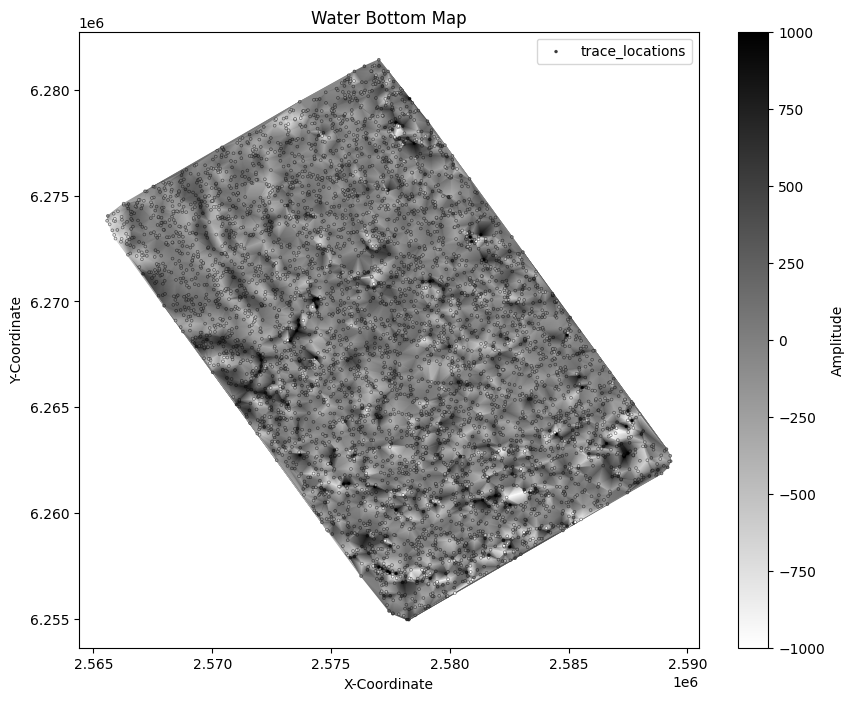

In [16]:
plt.figure(figsize=(10, 8))

z_slice_index = 500

x, y, z = (
    trace_headers["cdp-x"],
    trace_headers["cdp-y"],
    traces.sample[:, z_slice_index],
)

scatter_kw = {"ec": [0.0, 0.0, 0.0, 0.5], "linewidth": 0.5}
color_kw = {"cmap": "gray_r", "vmin": -1000, "vmax": 1000}

plt.tripcolor(x, y, z, shading="gouraud", **color_kw)
plt.scatter(x, y, s=4, c=z, label="trace_locations", **scatter_kw, **color_kw)
plt.title("Water Bottom Map")
plt.colorbar(label="Amplitude")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.legend();